In [2]:
import torch
import glob as gb
import numpy as np
from PIL import Image
import os

import random
import torch.nn as nn
import pandas as pd 

from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random

from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

os.sys.path.append('../')
from utils.loss import cos_sim

random.seed(1)
np.random.seed(1)

In [3]:
# SR Model Initialization

GPU_IN_USE = torch.cuda.is_available()

if GPU_IN_USE:
    cudnn.benchmark = True
    
device = torch.device('cuda' if GPU_IN_USE else 'cpu')
model_path = '../models/SRCNN_x4_epoch_50.pth'

model = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(0))
model = model.to(device)

In [12]:
# Testing upsampling

def load_image(path='', resize=True, size=160): # Bicubic
    img = Image.open(path)
    if resize:
        img = img.resize((size,size), resample=Image.BICUBIC)
    return img

In [13]:
# Testing SR

def load_image(path='', resize=True, size=160): # SR
    img = Image.open(path).convert('YCbCr').resize((160,160),resample=Image.BICUBIC)
    y, cb, cr = img.split()
    
    data = (transforms.ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    data = data.to(device)
    
    out = model(data)
    out = out.cpu()
    
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')

    return out_img

In [18]:
class SuperResolveDL:
    def __init__(self, model, size, channel):
        self.model = model
        self.size = size
        self.channel = channel
        
    def __call__(self, path=''):
        if self.channel == 1:
            img = Image.open(path).convert('YCbCr').resize((self.size,self.size),resample=Image.BICUBIC)
            y, cb, cr = img.split()
        elif self.channel == 3:
            img = Image.open(path).convert('RGB').resize((self.size,self.size),resample=Image.BICUBIC)
        else:
            raise Exception('Channel option not listed')
            
        data = (transforms.ToTensor()(y)).view(1, self.channel, y.size[1], y.size[0])
        data = data.to(device)
        out = self.model(data)
        out = out.cpu()
        out_img = out.data[0].numpy()
        out_img *= 255.0
        out_img = out_img.clip(0, 255)
        
        if self.channel == 1:
            out_img = Image.fromarray(np.uint8(out_img[0]), mode='L')
            out_img = Image.merge('YCbCr', [out_img, cb, cr]).convert('RGB')
        
        if self.channel == 3:
            out_img = Image.fromarray(np.uint8(out_img), mode='RGB')

        return out_img

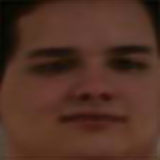

In [21]:
test = SuperResolveDL(model, size=160, channel=1)
test(gallery_path[2])

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [11]:
def return_embedding(img_path):
    img_as_tensor = transforms.ToTensor()(load_image(img_path))
    img_emb = resnet(img_as_tensor.unsqueeze(0)).squeeze(0).detach().numpy()
    return img_emb

def return_batch_embedding(imgs_path):
    img_array = [transforms.ToTensor()(load_image(path)) for path in imgs_path]
    emb_array = [resnet(img.unsqueeze(0)).squeeze(0).detach().numpy() for img in img_array]
    return np.array(emb_array)

In [7]:
#img_path = '/media/angelo/DATEN/Datasets/ICB-RW/Margin1.3_112/'
img_path = '/media/angelo/DATEN/Datasets/ICB-RW/NoMargin_112/'

gallery_path = gb.glob(img_path + 'gallery/*.jpg')
gallery_names = [str(int(os.path.splitext(name)[0][:-2])) for name in os.listdir(img_path + 'gallery/')]

face_embeddings = return_batch_embedding(gallery_path)

In [17]:
# Checking consistency

probe_path = img_path + 'probe/'
student_pool_list = gallery_names

real_embedding = return_embedding(img_path + 'gallery/00' + student_pool_list[0] + '_f.jpg')

guilty_student_path = gb.glob(probe_path + student_pool_list[0] + '/*.jpg')
sample_1_student = gb.glob(probe_path + student_pool_list[1] + '/*.jpg')
sample_2_student = gb.glob(probe_path + student_pool_list[2] + '/*.jpg')
sample_3_student = gb.glob(probe_path + student_pool_list[3] + '/*.jpg')

print('For student ' + student_pool_list[0])
print('Similarity with his own probe photos: ')

guilty_student_emb = return_batch_embedding(guilty_student_path)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[1])

guilty_student_emb = return_batch_embedding(sample_1_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[2])

guilty_student_emb = return_batch_embedding(sample_2_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[3])

guilty_student_emb = return_batch_embedding(sample_3_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

For student 12
Similarity with his own probe photos: 
[0.3222731947898865, 0.43873757123947144, 0.30629849433898926, 0.25737929344177246, 0.5448243916034698]
Similarity with probe photos of 3
[0.7098439335823059, 0.8020781725645065, 0.8511321246623993, 0.8808587938547134, 0.855574369430542]
Similarity with probe photos of 100
[0.8595972955226898, 0.7776927202939987, 0.7140221893787384, 0.9066499024629593, 0.8686856180429459]
Similarity with probe photos of 101
[0.6755765974521637, 0.6969212293624878, 0.7164497971534729, 0.8487648367881775, 0.9582072533667088]


In [22]:
# Experimentation
probe_path = img_path + 'probe/'
student_pool_list = gallery_names
accuracy = 0
error = []

for index, student in enumerate(student_pool_list):
    probe_list_students = student_pool_list.copy()
    watch_list_emb = []
    watch_list_images = []
    
    # First embeddings is always for the guilty student  
    guilty_student_image = probe_path + student + '/' + random.choice(os.listdir(probe_path + student))
    watch_list_emb.append(return_embedding(guilty_student_image))
    
    probe_list_students.remove(student)
    
    watch_list_students = random.sample(probe_list_students, 4)
    
    for suspect in watch_list_students:
        image = random.choice(os.listdir(probe_path + suspect))
        watch_list_images.append(probe_path + suspect + '/' + image)
        
    for suspect in watch_list_images:
        watch_list_emb.append(return_embedding(suspect))
    
    similarities = [cos_sim(face_embeddings[index], watch_list_emb[i]) for i in range(5)]
    
    # If the least distance is the first element, let's sum 1
    if np.argmin(np.array(similarities)) == 0:
        accuracy += 1
    else:
        error.append(student)
        #print('Error happened with student: ' + student)
        #print(pd.DataFrame(similarities))
        #print('------------------------------------------------')
    #print('Student {}/{}'.format(index+1,len(student_pool_list)))
    #print('For student ' + student)
    #print(pd.DataFrame(similarities))
    #print('------------------------------------------------')
    
print("Accuracy: {0:.2f}".format(accuracy/len(student_pool_list)))
print('Error happend with the following students: ')
print(error)

Accuracy: 0.81
Error happend with the following students: 
['100', '105', '109', '112', '6', '76', '79', '7', '92', '93', '13', '172', '175', '18', '19', '27', '33']
